In [1]:
import os
import glob
import pickle
import numpy as np
import tensorflow as tf
from scipy import io as spio
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

# ROOTDIR_DATA = "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/"
# ROOTDIR_SRC = "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP/src"
ROOTDIR_DATA = "/space/ponzio/teaching-MLinAPP"
ROOTDIR_SRC = "/space/ponzio/teaching-MLinAPP/src"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !rm -r "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"
# !git clone https://github.com/frpnz/teaching-MLinAPP.git "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"
plt.style.use(os.path.join(ROOTDIR_SRC, "mystyle.mplstyle"))
import sys
sys.path.append(ROOTDIR_SRC)

# Thresholding the uncertain

## Load original and corrupted data

### Cifar10
Do not shuffle the dataset

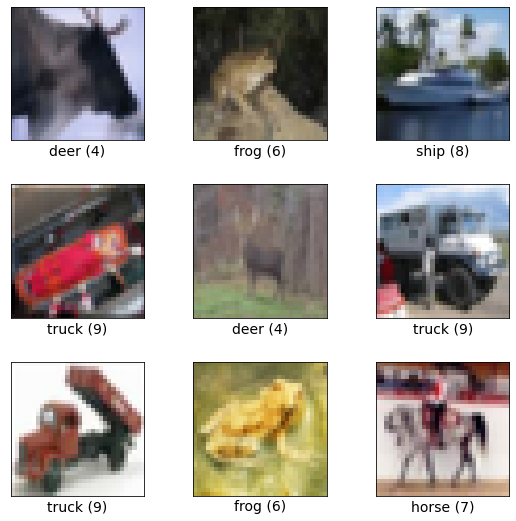

In [4]:
def process_data(image, label):
    return tf.cast(image, tf.float32)/255., tf.one_hot(label, 10, name='label', axis=-1)

(cifar10_train, cifar10_test), cifar10_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

fig = tfds.show_examples(cifar10_train, cifar10_info)

cifar10_train = cifar10_train.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_train = cifar10_train.cache()
cifar10_train = cifar10_train.batch(128)
cifar10_train = cifar10_train.prefetch(tf.data.AUTOTUNE)

cifar10_test = cifar10_test.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_test = cifar10_test.cache()
y_true_cifar10 = np.array([y.numpy() for x, y in cifar10_test])
cifar10_test = cifar10_test.batch(128)
cifar10_test = cifar10_test.prefetch(tf.data.AUTOTUNE)

### Corrupted dataset
Do not shuffle the dataset

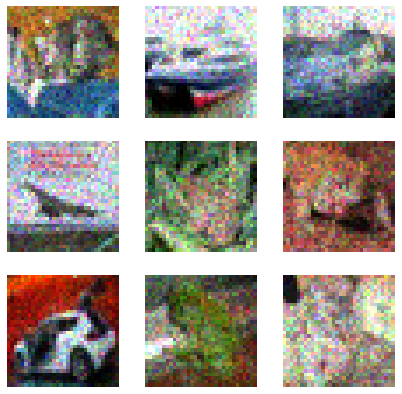

In [5]:
corruption_level = 4
corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/shot_noise.npy"))
corruption = corruption[corruption_level*10000:(corruption_level+1)*10000]
label_corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/labels.npy")
)[corruption_level*10000: (corruption_level+1)*10000]

# Train test split
corruption_train, corruption_test = train_test_split(corruption, test_size=0.5)
label_corruption_train, label_corruption_test = train_test_split(label_corruption, test_size=0.5)

corruption_train_ds = tf.data.Dataset.from_tensor_slices((corruption, label_corruption))
fig, ax = plt.subplots(3, 3, figsize=(7, 7))
ax = ax.ravel()
j = 0
for x, y in corruption_train_ds.take(9):
    ax[j].imshow(x.numpy())
    ax[j].axis('off')
    j += 1
corruption_train_ds = corruption_train_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
corruption_train_ds = corruption_train_ds.cache()
corruption_train_ds = corruption_train_ds.batch(128)
corruption_train_ds = corruption_train_ds.prefetch(tf.data.AUTOTUNE)

corruption_test_ds = tf.data.Dataset.from_tensor_slices((corruption, label_corruption))
corruption_test_ds = corruption_test_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
corruption_test_ds = corruption_test_ds.cache()
corruption_test_ds = corruption_test_ds.batch(128)
corruption_test_ds = corruption_test_ds.prefetch(tf.data.AUTOTUNE)

## Load pre-trained CNN

In [6]:
from resnet import ResNet
input_shape = (32, 32, 3)
num_classes = 10
draws = 5 #  with 'all' as TTA policy this means draws*4 total samples
model = ResNet((input_shape[0], input_shape[1]), 
               num_classes=num_classes, 
               augment=True)
model.compile(metrics=["accuracy"])
model.built = True
model.load_weights(os.path.join(ROOTDIR_DATA, "models_cifar/checkpoint_cifar10_lr_red"))

## Evaluate on test folds

In [7]:
results_cifar = model.evaluate(cifar10_test, verbose=0)
results_corruption = model.evaluate(corruption_test_ds, verbose=0)
print("Accuracy on cifar10 test set: {:.2f}".format(results_cifar[1]))
print("Accuracy on noisy cifar10 test set: {:.2f}".format(results_corruption[1]))

Accuracy on cifar10 test set: 0.83
Accuracy on noisy cifar10 test set: 0.30


In [8]:
class TTAWrapper:
    def __init__(self, keras_model, input_shape=(32, 32, 3)):
        super(TTAWrapper, self).__init__()
        self.model = keras_model
        self._input_shape = input_shape
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(
            metric, 
            multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def _avreage_prediction(self, multiple_preds):
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
            return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return  np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

    def predict_many_times(self, ds, policy, draws=1):
        pred_augmented = list()

        policy_random_crop = [
            tf.keras.Sequential([
                tf.keras.layers.RandomCrop(int(self._input_shape[0] - 0.1*self._input_shape[0]),
                                           int(self._input_shape[0] - 0.1*self._input_shape[0])),
                tf.keras.layers.Resizing(self._input_shape[0],
                                         self._input_shape[1])])]

        policy_random_flip = [
            tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal_and_vertical")])
        ]

        policy_random_contrast = [
            tf.keras.Sequential([
                tf.keras.layers.RandomContrast(0.2, 0.2)])
        ]

        policy_random_zoom = [
            tf.keras.Sequential([
                tf.keras.layers.RandomZoom(height_factor=(-0.2, .2),
                                           width_factor=(-0.2, .2))])
        ]

        policy_identity = [tf.keras.Sequential([
            tf.keras.layers.Layer()])]

        policies = dict()
        policies['identity'] = policy_identity
        policies['random_crop'] = policy_random_crop
        policies['random_contrast'] = policy_random_contrast
        policies['random_zoom'] = policy_random_zoom
        policies['random_flip'] = policy_random_flip
        policies['all'] = sum([policy_random_crop, policy_random_contrast, policy_random_zoom, policy_random_flip], [])

        policies['random_crop'] = sum([policies['random_crop'] for _ in range(draws)], [])
        policies['random_contrast'] = sum([policies['random_contrast'] for _ in range(draws)], [])
        policies['random_zoom'] = sum([policies['random_zoom'] for _ in range(draws)], [])
        policies['random_flip'] = sum([policies['random_flip'] for _ in range(draws)], [])
        policies['all'] = sum([policies['all'] for _ in range(draws)], [])

        for p in policies[policy]:
            ds_augmented = ds.map(lambda x, y: (p(x, training=True), y))
            pred_augmented.append(self.model.predict(ds_augmented))

        return pred_augmented


In [9]:
tta_model = TTAWrapper(model)

## Make predictions for cifar and corrupted datasets

In [10]:
cifar10_preds = model.predict(cifar10_test)
corruption_preds = model.predict(corruption_test_ds)
cifar10_many_preds = tta_model.predict_many_times(cifar10_test, "all", draws=draws)
corruption_many_preds = tta_model.predict_many_times(corruption_test_ds, "all", draws=draws)

## Plot uncertianties distributions

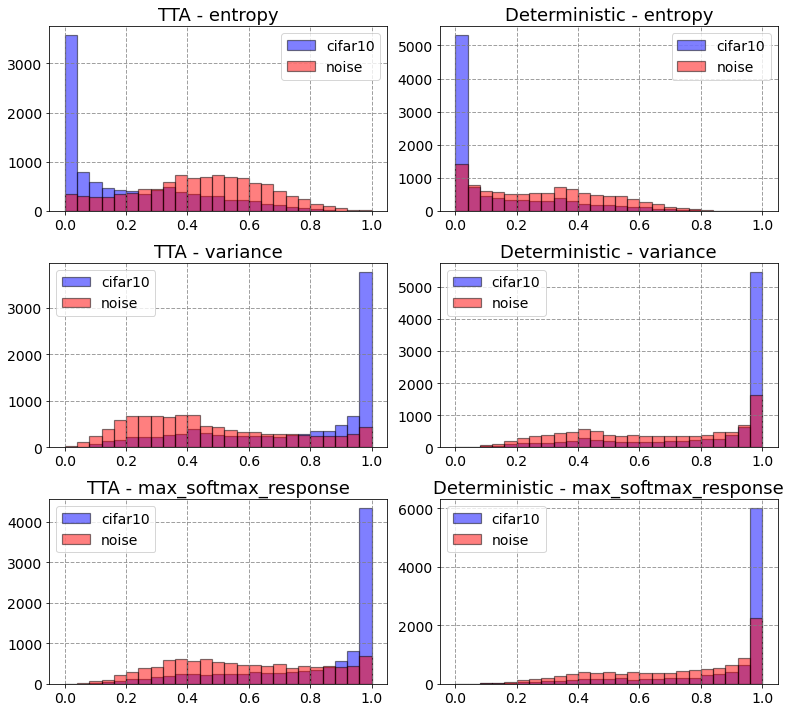

In [11]:
uncertainties = dict()
uncertainties['cifar10_probabilistic'] = (tta_model.uncertainty_metrics(np.array(cifar10_many_preds)), 
                                          cifar10_many_preds, y_true_cifar10)
uncertainties['corrupted_probabilistic'] = (tta_model.uncertainty_metrics(np.array(corruption_many_preds)), 
                                            corruption_many_preds, label_corruption)
uncertainties['cifar10_deterministic'] = (tta_model.uncertainty_metrics(cifar10_preds), 
                                          cifar10_preds, y_true_cifar10)
uncertainties['corrupted_deterministic'] = (tta_model.uncertainty_metrics(corruption_preds), 
                                            corruption_preds, label_corruption)
fig, axes = plt.subplots(len(tta_model._uncertainty_metrics.keys()), 2, figsize=(11, 10))
for ax, measure in zip(axes, tta_model._uncertainty_metrics.keys()):
    ax[0].set_title(f"TTA - {measure}")
    ax[0].hist(uncertainties['cifar10_probabilistic'][0][measure], 
               color="blue", 
               log=False, 
               bins=25, 
               edgecolor='black', 
               linewidth=1.2, 
               alpha=0.5, 
               label="cifar10");
    ax[0].hist(uncertainties['corrupted_probabilistic'][0][measure], 
               color="red", 
               log=False, 
               bins=25, 
               edgecolor='black', 
               linewidth=1.2, 
               alpha=0.5, 
               label="noise");
    ax[0].legend()
    # Deterministic
    ax[1].set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties['cifar10_deterministic'][0][measure], 
               color="blue", 
               log=False, 
               bins=25, 
               edgecolor='black', 
               linewidth=1.2,
               alpha=0.5, 
               label="cifar10");
    ax[1].hist(uncertainties['corrupted_deterministic'][0][measure], 
               color="red", 
               log=False, 
               bins=25, 
               edgecolor='black', 
               linewidth=1.2, 
               alpha=0.5, 
               label="noise");
    ax[1].legend()
    plt.tight_layout()

Now we can put a threshold $\theta$ on the uncertainties distribution to identify, and eventually remove, those **not-confident** predictions.The following procedure will provide a method to automatically identify such threshold

# Risk-Coverage analysis

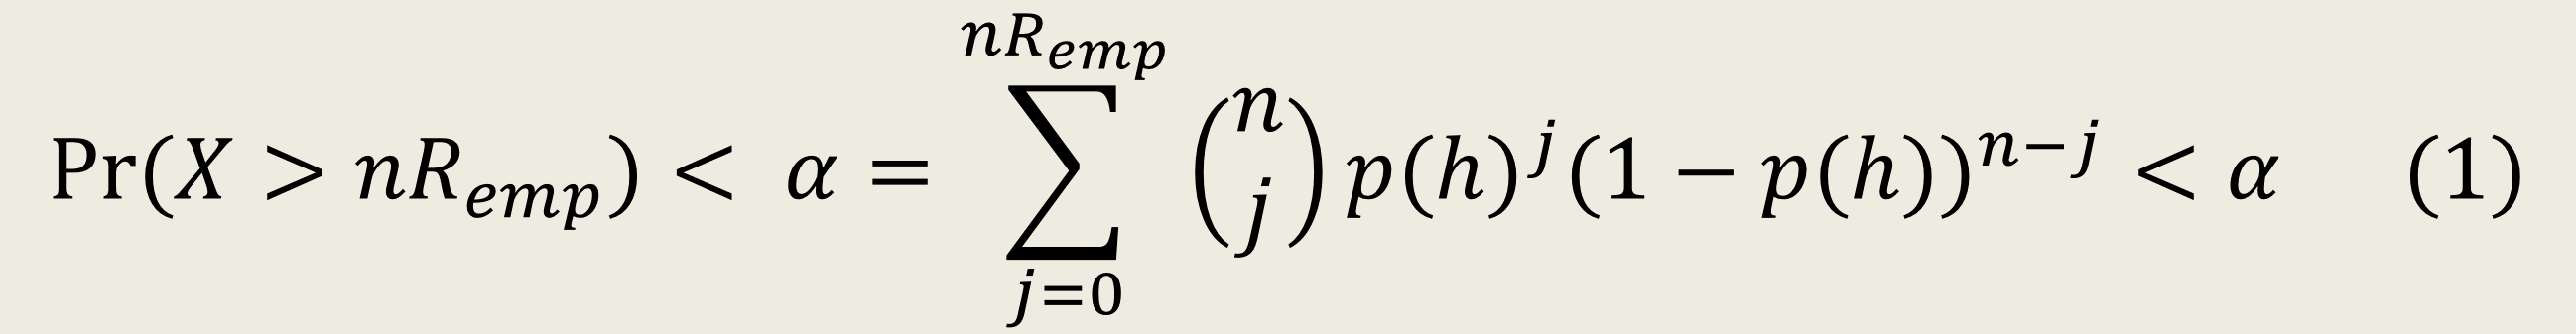

*   This means: **“We want the probability of observing more than $R_{𝑒𝑚𝑝}$ errors in n trials less than 𝛼”**
*   The inequation (1) depends on **p**, the **true risk**
*   Fixed the empirical risk, we evaluate which p ensures (1) by computing the cumulative density function of a binomial with parameters p, n, empirical risk 


In [12]:
import scipy.stats
def get_risk_bound(n, r_emp, alpha=0.01):
    p_array = np.linspace(0, 1, 100)
    probabilities = np.array(
        [scipy.stats.binom.cdf(r_emp*n, n, p) for p in p_array])
    return p_array[np.where(probabilities < alpha)][0]

Now we can vary the empirical risk thanks to a selection function $𝑔_𝜃 (𝑥)$, based on a confidence measure 𝜅


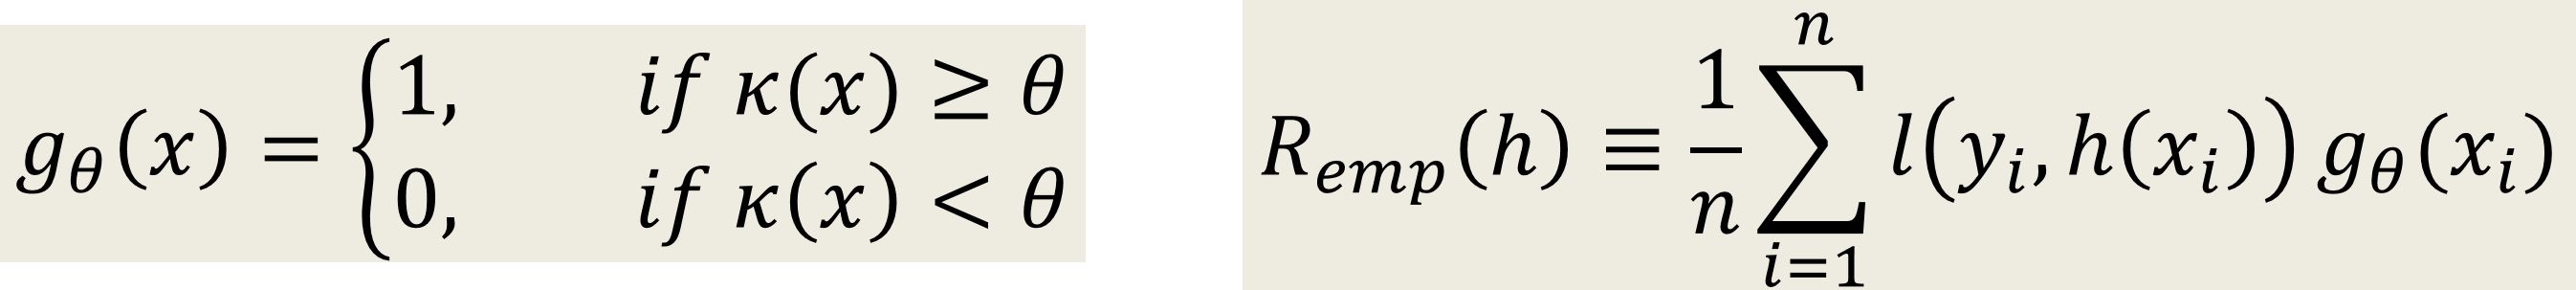

The empirical risk can be traded-off by coverage
*   Coverage is defined as the probability mass of the non-rejected region in X (i.e., the observed number of non-rejected samples)
*   That is, among all the classifiers satisfying $Pr⁡(𝑋>𝑛𝑅_{𝑒𝑚𝑝})< 𝛼$ the best one is that which maximize the coverage
*   The performance profile of the classifier can be specified by risk-coverage curves

Notably, **fixed an acceptable true risk $𝑅^∗$, $\alpha$, and 𝜅 we can obtain the threshold 𝜃 and the corresponding coverage**

**Note that the tailoring of the threshold $\theta$ must be done on the training dataset**

## Function to get $\theta$, i.e., the threshold on the confidence meaure.

In [13]:
def get_theta(y_pred, y_true, r, alpha, confidence_values):
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
    thetas = np.array([_ for _ in np.linspace(0, 1, 10)])
    coverages = list()
    risk_bounds = list()
    for theta in thetas:
        try:
            inliers = y_pred[confidence_values > theta]
            inliers_lables = y_true[confidence_values > theta]
            errors = sum(inliers != inliers_lables)
            risk = errors / len(inliers)
            coverages.append(len(inliers) / len(y_pred))
            risk_bounds.append(get_risk_bound(n=len(inliers), 
                                              r_emp=risk, 
                                              alpha=alpha))
        except ZeroDivisionError:
            coverages.append(0)
            risk_bounds.append(0)
    risk_bounds = np.array(risk_bounds)
    indexes = risk_bounds == risk_bounds[risk_bounds <= r][0]
    if sum(indexes) > 1:
        first_true = np.where(indexes == True)[0][0]
        indexes = np.zeros(len(indexes), dtype=bool)
        indexes[first_true] = True
    return float(thetas[indexes]), float(np.array(coverages)[indexes]), float(risk_bounds[indexes])

## Create a mixed dataset (both original and corrupted images)
**Note that the setting of the threshold $\theta$ must be done on the training dataset**

In [ ]:
cifar10_preds = model.predict(cifar10_train)
corruption_preds = model.predict(corruption_train_ds)
cifar10_many_preds = tta_model.predict_many_times(cifar10_train, "all", draws=draws)
corruption_many_preds = tta_model.predict_many_times(corruption_train_ds, "all", draws=draws)

In [ ]:
a = np.array([d[:7500] for d in cifar10_many_preds])
b = np.array([d[7500:] for d in corruption_many_preds])
uncertainties['mixed_probabilistic'] = (tta_model.uncertainty_metrics(np.concatenate((a, b), axis=1)), 
                                        np.concatenate((a, b), axis=1),
                                        np.concatenate((np.argmax(y_true_cifar10, axis=1)[:7500], 
                                                        label_corruption[7500:]), axis=0))
a = cifar10_preds[:7500]
b = corruption_preds[7500:]
uncertainties['mixed_deterministic'] = (tta_model.uncertainty_metrics(np.concatenate((a, b), axis=0)), 
                                        np.concatenate((a, b), axis=0),
                                        np.concatenate((np.argmax(y_true_cifar10, axis=1)[:7500], 
                                                        label_corruption[7500:]), axis=0))

## Compute coverage at a given risk for all the dataset and considering all the confidence metrics

In [ ]:
risks = np.linspace(0, 1, 10)
coverage_stats = dict()
for risk in risks:
    risk = np.round(risk, decimals=1)
    coverage_stats[risk] = dict()
    for dataset in uncertainties.keys():
        coverage_stats[risk][dataset] = dict()
        y_true = uncertainties[dataset][2]
        y_preds = np.array(uncertainties[dataset][1])
        if len(y_preds.shape) > 2:
            y_preds = np.mean(y_preds, axis=0)
        for measure_key in uncertainties[dataset][0].keys():
            if measure_key == 'entropy':
                measure = 1 - uncertainties[dataset][0][measure_key]
            else:
                measure = uncertainties[dataset][0][measure_key]

            (theta, coverage, risk_bound) = get_theta(y_preds,
                                                      y_true,
                                                      risk, 
                                                      0.01, 
                                                      measure)
            coverage_stats[risk][dataset][measure_key] = dict()
            coverage_stats[risk][dataset][measure_key]['theta'] = theta
            coverage_stats[risk][dataset][measure_key]['coverage'] = coverage
            coverage_stats[risk][dataset][measure_key]['risk_bound'] = risk_bound

## Plot bars to see the coverages

In [ ]:
positions = np.arange(1, 7)
deltas = [-0.2, 0, 0.2]
hatches = ['\\', '//', '.']
colors = [0.45, 0.65, 0.85]
width = 0.2
for risk in coverage_stats.keys():
    k = 0
    coverage_data = coverage_stats[risk]
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    for dataset, confidence in sorted(coverage_data.items()):
        j = 0
        for metric in list(tta_model._uncertainty_metrics.keys()):
            if k==0:
                label = metric
            else:
                label = None
            ax.bar(positions[k] + deltas[j], confidence[metric]['coverage']*100, 
                   width=width,
                   color=[colors[j]]*3,
                   hatch=hatches[j],
                   label=label,
                   zorder=2)
            j += 1
        k +=1
    ax.legend(loc=(1.04, 0.5))
    ax.set_xticks(positions)
    ax.set_xticklabels(sorted(coverage_data.keys()), rotation=90);
    ax.set_title("Risk: {}".format(risk));
    ax.set_ylabel("Coverage".format(risk));

## Explore all corruptions for all corruption levels with a mixed dataset 

In [ ]:
PREDICT = True
if PREDICT:
    n_samples = 4000
    confidence_data_all_corruptions = dict()
    label_corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/labels.npy"))
    for corruption_level in [0, 1, 2, 3, 4]:
        confidence_data_all_corruptions[corruption_level] = dict()
        for filepath in glob.glob(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/*.npy")):
            corruption_type = os.path.basename(filepath).split('.')[0]
            if "labels" in corruption_type:
                continue
            confidence_data_all_corruptions[corruption_level][corruption_type] = dict()
            print("Doing {}-{}".format(corruption_type, corruption_level))
            corruption = np.load(filepath)
            corruption = corruption[corruption_level*10000:corruption_level*10000+n_samples]
            label_corr = label_corruption[corruption_level*10000:corruption_level*10000+n_samples]
            corruption_train_ds = tf.data.Dataset.from_tensor_slices((corruption, label_corr))
            corruption_train_ds = corruption_train_ds.map(
                process_data, num_parallel_calls=tf.data.AUTOTUNE)
            corruption_train_ds = corruption_train_ds.cache()
            corruption_train_ds = corruption_train_ds.batch(128)
            corruption_train_ds = corruption_train_ds.prefetch(tf.data.AUTOTUNE)
            # Create a mixed probabilistic dataset
            a = np.array([d[n_samples:] for d in cifar10_many_preds])
            b = tta_model.predict_many_times(corruption_train_ds, 
                                             "all", 
                                             draws=draws)
            confidence_data_all_corruptions[corruption_level][corruption_type]['probabilistic'] = (
                tta_model.uncertainty_metrics(
                    np.concatenate((a, b), axis=1)), 
                np.concatenate((a, b), axis=1),
                np.concatenate((np.argmax(y_true_cifar10, axis=1)[n_samples:], 
                                label_corr), axis=0)
            )
            # Create a mixed deterministic dataset
            a = cifar10_preds[n_samples:]
            b = model.predict(corruption_train_ds)
            confidence_data_all_corruptions[corruption_level][corruption_type]['deterministic'] = (
                tta_model.uncertainty_metrics(
                    np.concatenate((a, b), axis=0)), 
                np.concatenate((a, b), axis=0),
                np.concatenate((np.argmax(y_true_cifar10, axis=1)[n_samples:], 
                                label_corr), axis=0)
            )
    filepath = os.path.join(ROOTDIR_DATA, "confidence_data_all_corruptions.pickle")
    with open(filepath, "wb") as fp:
        pickle.dump(confidence_data_all_corruptions, fp)
else:
    filepath = os.path.join(ROOTDIR_DATA, "confidence_data_all_corruptions.pickle")
    with open(filepath, "rb") as fp:
        confidence_data_all_corruptions = pickle.load(fp)

### Fix corruption level

In [ ]:
risk = 0.2
stats = dict()
# Loop on corruption level
for level in confidence_data_all_corruptions.keys():
    # Prepare dict
    for key in tta_model._uncertainty_metrics.keys():
        key = '-'.join([key, "probabilistic"])
        stats[key] = dict()
        stats[key]['theta'] = list()
        stats[key]['coverage'] = list()
        stats[key]['risk_bound'] = list()
        key = '-'.join([(key).split('-')[0], "deterministic"])
        stats[key] = dict()
        stats[key]['theta'] = list()
        stats[key]['coverage'] = list()
        stats[key]['risk_bound'] = list()
    # Loop on corruption type
    for corruption_type in confidence_data_all_corruptions[level].keys():
        # Loop on deterministic or probabilistic
        for uncertainty_type, uncertainty_data in confidence_data_all_corruptions[level][corruption_type].items():
            y_true = uncertainty_data[2]
            y_preds = uncertainty_data[1]
            if len(y_preds.shape) > 2:
                y_preds = np.mean(y_preds, axis=0)
            for measure_key in uncertainty_data[0].keys():
                if measure_key == 'entropy':
                    measure = 1 - uncertainty_data[0][measure_key]
                else:
                    measure = uncertainty_data[0][measure_key]

                (theta, coverage, risk_bound) = get_theta(y_preds,
                                                          y_true,
                                                          risk, 
                                                          0.01, 
                                                          measure)
                stats['-'.join([measure_key, uncertainty_type])]['theta'].append(theta)
                stats['-'.join([measure_key, uncertainty_type])]['coverage'].append(coverage)
                stats['-'.join([measure_key, uncertainty_type])]['risk_bound'].append(risk_bound)
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    colors = ['firebrick', 'forestgreen', 'royalblue']
    j = 0
    for metric in tta_model._uncertainty_metrics.keys():
        ax.plot(stats['-'.join([metric, "probabilistic"])]['coverage'], 
                label='-'.join([metric, "probabilistic"]),
                linewidth=3,
                color=colors[j],
                linestyle=(0, (1, 1)))
        ax.plot(stats['-'.join([metric, "deterministic"])]['coverage'],
                linewidth=2,
                color=colors[j],
                label='-'.join([metric, "deterministic"]))
        j += 1
    ax.legend(loc=(1.04, 0.5))
    ax.set_xlabel('corruption type')
    ax.set_ylabel('coverage')
    ax.set_ylim([0, 1.1])
    ax.set_xticks(np.arange(len(stats['-'.join([metric, "probabilistic"])]['coverage'])))
    ax.set_xticklabels(confidence_data_all_corruptions[0].keys(), rotation=90)
    ax.set_title("corruption level: {}".format(level))

### Fix corruption type

In [ ]:
risk = 0.2
for corruption_type in confidence_data_all_corruptions[level].keys():
    stats = dict()
    # Prepare dict
    for key in tta_model._uncertainty_metrics.keys():
        key = '-'.join([key, "probabilistic"])
        stats[key] = dict()
        stats[key]['theta'] = list()
        stats[key]['coverage'] = list()
        stats[key]['risk_bound'] = list()
        key = '-'.join([(key).split('-')[0], "deterministic"])
        stats[key] = dict()
        stats[key]['theta'] = list()
        stats[key]['coverage'] = list()
        stats[key]['risk_bound'] = list()
    # Fix corruption type and loop on deterministic or probabilistic
    for level in [0, 1, 2, 3, 4]:
        for uncertainty_type, uncertainty_data_by_corruption in confidence_data_all_corruptions[level][corruption_type].items():
            y_true = uncertainty_data_by_corruption[2]
            y_preds = uncertainty_data_by_corruption[1]
            if len(y_preds.shape) > 2:
                y_preds = np.mean(y_preds, axis=0)
            for measure_key in uncertainty_data_by_corruption[0].keys():
                if measure_key == 'entropy':
                    measure = 1 - uncertainty_data_by_corruption[0][measure_key]
                else:
                    measure = uncertainty_data_by_corruption[0][measure_key]

                (theta, coverage, risk_bound) = get_theta(y_preds,
                                                          y_true,
                                                          risk, 
                                                          0.01, 
                                                          measure)
                stats['-'.join([measure_key, uncertainty_type])]['theta'].append(theta)
                stats['-'.join([measure_key, uncertainty_type])]['coverage'].append(coverage)
                stats['-'.join([measure_key, uncertainty_type])]['risk_bound'].append(risk_bound)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    colors = ['firebrick', 'forestgreen', 'royalblue']
    j = 0
    for metric in tta_model._uncertainty_metrics.keys():
        ax.plot(stats['-'.join([metric, "probabilistic"])]['coverage'], 
                label='-'.join([metric, "probabilistic"]),
                linewidth=3,
                color=colors[j],
                linestyle=(0, (1, 1)))
        ax.plot(stats['-'.join([metric, "deterministic"])]['coverage'],
                linewidth=2,
                color=colors[j],
                label='-'.join([metric, "deterministic"]))
        j += 1
    ax.legend(loc=(1.04, 0.5))
    ax.set_xlabel('corruption level')
    ax.set_ylabel('coverage')
    ax.set_xticks(np.arange(len(stats['-'.join([metric, "probabilistic"])]['coverage'])))
    ax.set_title(corruption_type)
    ax.set_ylim([0, 1.1])